In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
submit_df = pd.read_csv("./submit_sample.csv", header=None)


In [8]:
# google colab
train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/test.csv")
submit_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/submit_sample.csv", header=None)

In [4]:
train_df.shape, test_df.shape, submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

In [5]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


<BarContainer object of 42 artists>

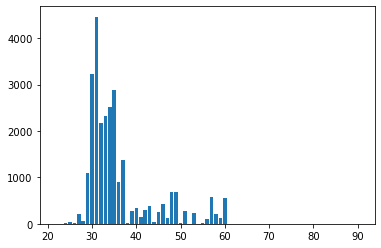

In [6]:
# それぞれの年齢におけるターゲットの数
plt.bar(train_df['age'].value_counts().sort_index().index, train_df['age'].value_counts().sort_index())

####  0  ~  9
#############################


####  10  ~  19
#############################


####  20  ~  29
#############################
22 1 1.0
24 8 1.0
25 35 5.0
26 10 3.0
27 222 13.0
28 66 7.0
29 1104 190.0
num_people is  1446


####  30  ~  39
#############################
30 3226 242.0
31 4464 202.0
32 2176 210.0
33 2318 135.0
34 2521 90.00000000000001
35 2888 123.00000000000001
36 907 31.0
37 1368 170.0
38 12 0.0
39 270 24.0
num_people is  20150


####  40  ~  49
#############################
40 333 28.999999999999996
41 153 5.0
42 307 46.0
43 385 22.0
44 39 5.0
45 252 28.0
46 435 53.0
47 115 5.0
48 675 54.0
49 683 76.0
num_people is  3377


####  50  ~  59
#############################
50 18 3.0
51 279 16.0
52 5 1.0
53 236 51.0
54 4 1.0
55 11 3.0
56 104 9.0
57 573 44.0
58 222 49.0
59 116 8.0
num_people is  1568


####  60  ~  69
#############################
60 546 157.0
63 6 0.0
num_people is  552


####  70  ~  79
#############################
73 1 0.0
77 1 0.0


####  80 

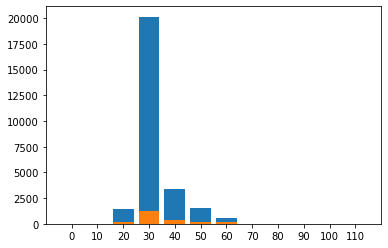

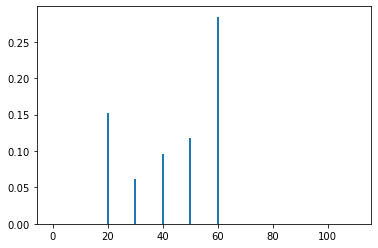

In [114]:
period = range(0, 120, 10)

# index : age (pandas Series obj)
#print(target_df["age"])
# the number of "y" in each colmun (numpy Array)
#print(np.array(target_df['y']) * np.array(train_df['age'].value_counts().sort_index()))
# list of age
#print(train_df['age'].value_counts().sort_index().index)

list_age = train_df['age'].value_counts().sort_index().index
target_df = train_df.groupby(['age'], as_index=False).mean()
sum_y = np.array(target_df['y']) * np.array(train_df['age'].value_counts().sort_index())


index = 0
num_people_list = np.zeros(len(period))
prob = np.zeros(len(period))
for i, lim_age in enumerate(period):
    num_people = 0
    print("#### ", lim_age, " ~ ", lim_age+10-1)
    print("#############################")
    for j, age in enumerate(list_age):
        if (age >= lim_age ) and (age < lim_age+10):
            print(age, np.array(train_df['age'].value_counts().sort_index())[j], sum_y[j])
            num_people += np.array(train_df['age'].value_counts().sort_index())[j]
            prob[i] += sum_y[j]
            index += 1
        else:
            if(lim_age+10-1 < age):
                break
    if (max(list_age) > age) and (num_people != 0):
        print("num_people is ", num_people)
        num_people_list[i] = num_people
        prob[i] /= num_people
    print("\n")

#num_people_list /= np.sum(num_people_list)    

#plt.show()
plt.bar(np.array(range(12)), num_people_list, tick_label=period)
plt.bar(np.array(range(12)), prob*num_people_list, tick_label=period)
plt.show()

plt.bar(period, prob)
plt.show()


In [8]:
# それぞれの年間平均残高におけるターゲットの数
tmp = round(train_df['balance'], -1).value_counts().sort_index()

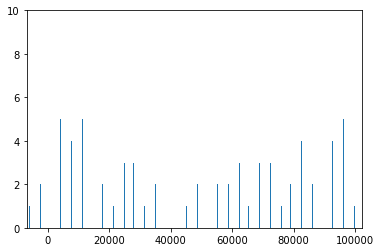

In [9]:
plt.bar(tmp.index, tmp)
plt.xlim(min(tmp.index), max(tmp.index))
plt.ylim(0, max(tmp))
plt.show()

In [92]:
def relationship(feature):
    tmp = train_df[feature].value_counts().sort_index()
    print(tmp.index)
    print(feature, "とキャンペーン参加人数の関係")
    plt.figure(figsize=(12, 7))
    plt.tick_params(labelsize=9)
    plt.bar(range(len(tmp.index)), np.array(tmp))
    plt.bar(np.array(range(len(tmp.index))), np.array(tmp)*np.array(train_df.groupby([feature], as_index=False).mean()['y']), tick_label=list(tmp.index))
    plt.show()

    print(feature, "とキャンペーン参加率の関係")
    plt.figure(figsize=(12, 7))
    plt.tick_params(labelsize=9)
    plt.bar(range(len(tmp.index)), np.array(train_df.groupby([feature], as_index=False).mean()['y']), tick_label=list(tmp.index))
    plt.show()

In [93]:
print(train_df.columns.values)

['id' 'age' 'job' 'marital' 'education' 'default' 'balance' 'housing'
 'loan' 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome' 'y']


Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed'],
      dtype='object')
job とキャンペーン参加人数の関係


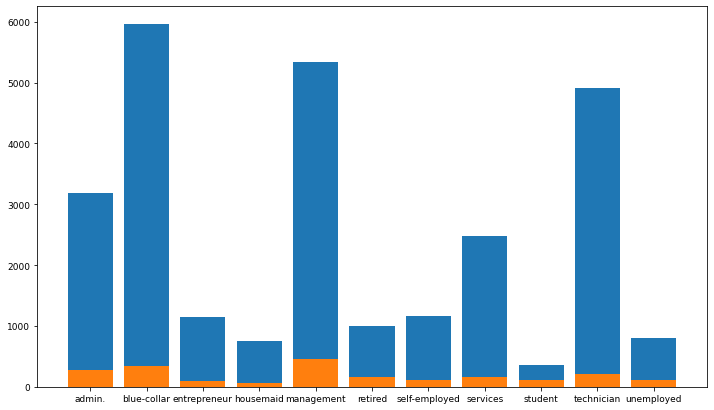

job とキャンペーン参加率の関係


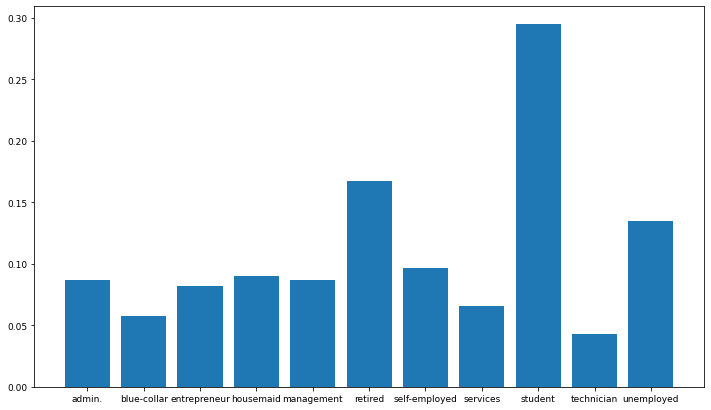

In [94]:
relationship("job")

Int64Index([22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
            40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
            57, 58, 59, 60, 63, 73, 77, 90],
           dtype='int64')
age とキャンペーン参加人数の関係


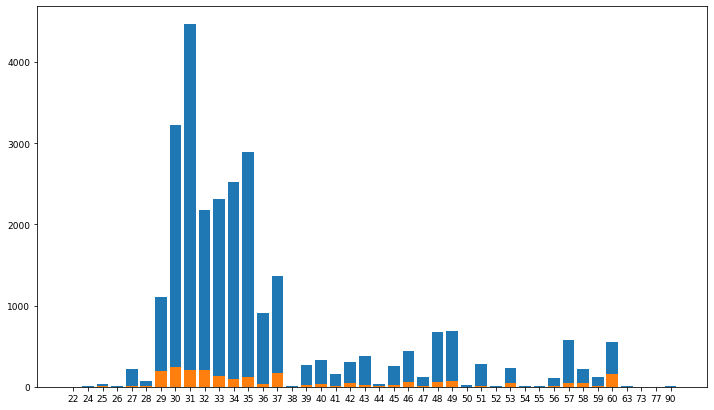

age とキャンペーン参加率の関係


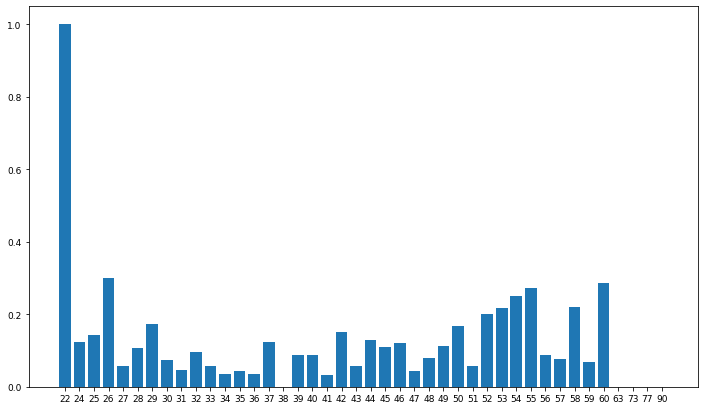

Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed'],
      dtype='object')
job とキャンペーン参加人数の関係


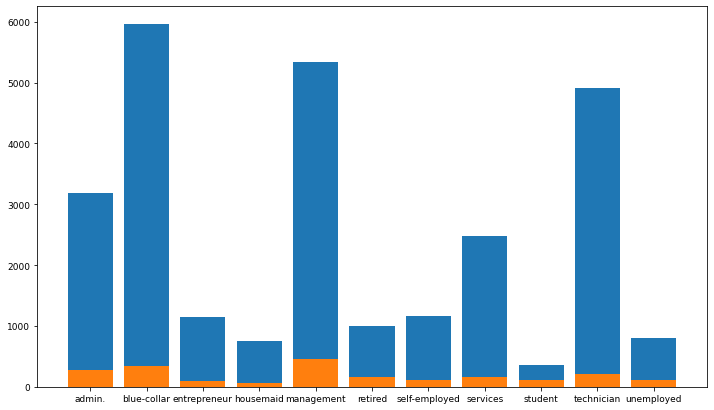

job とキャンペーン参加率の関係


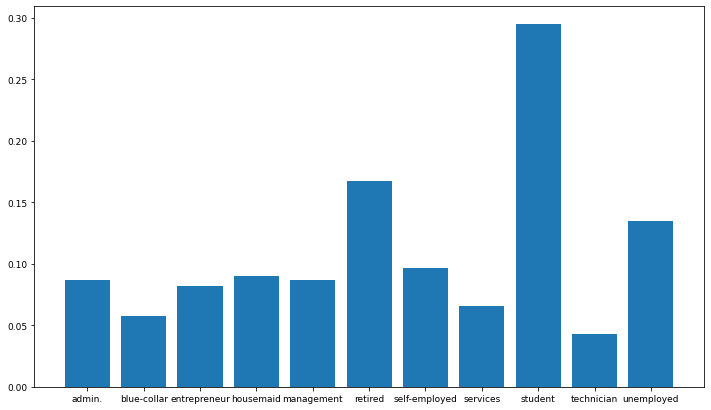

Index(['divorced', 'married', 'single'], dtype='object')
marital とキャンペーン参加人数の関係


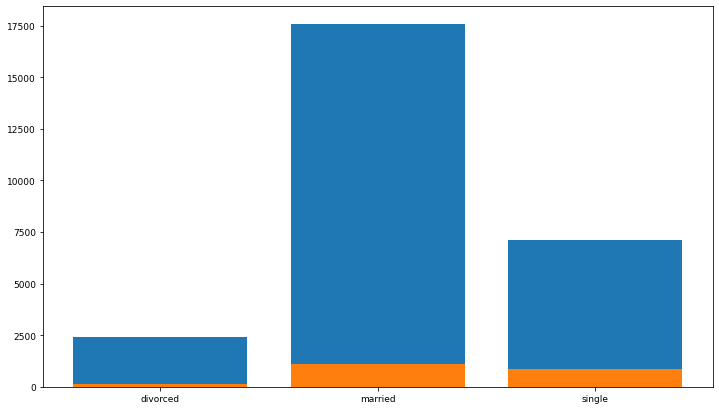

marital とキャンペーン参加率の関係


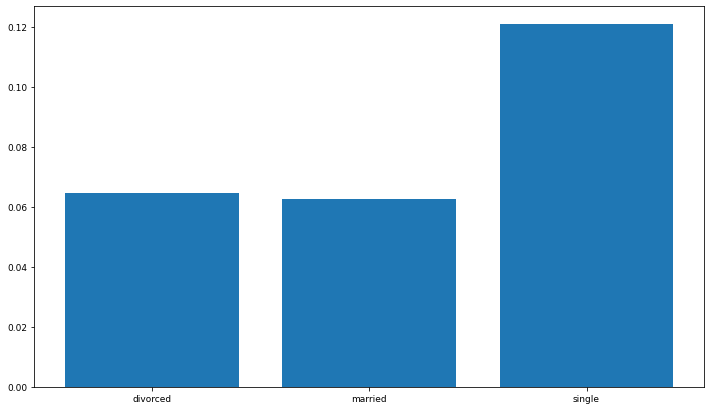

Index(['primary', 'secondary', 'tertiary', 'unknown'], dtype='object')
education とキャンペーン参加人数の関係


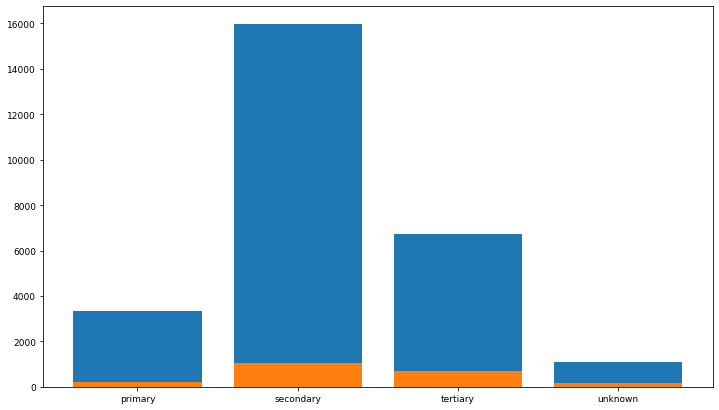

education とキャンペーン参加率の関係


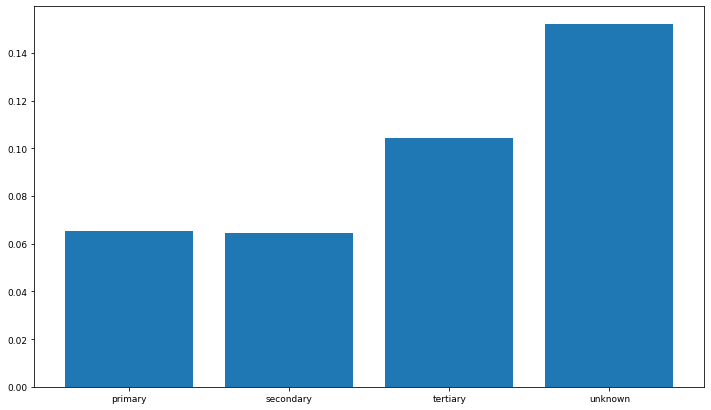

Index(['no', 'yes'], dtype='object')
default とキャンペーン参加人数の関係


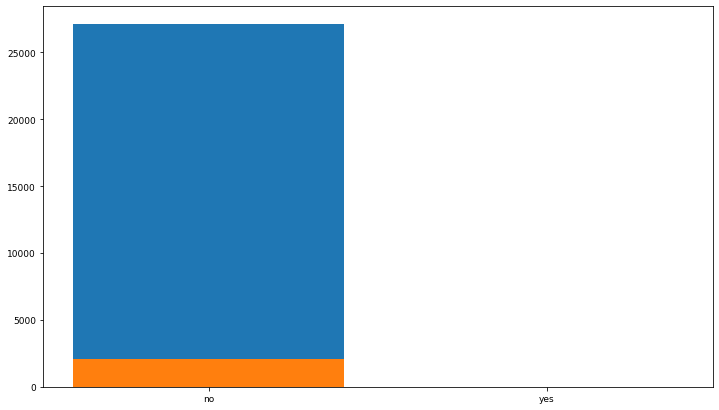

default とキャンペーン参加率の関係


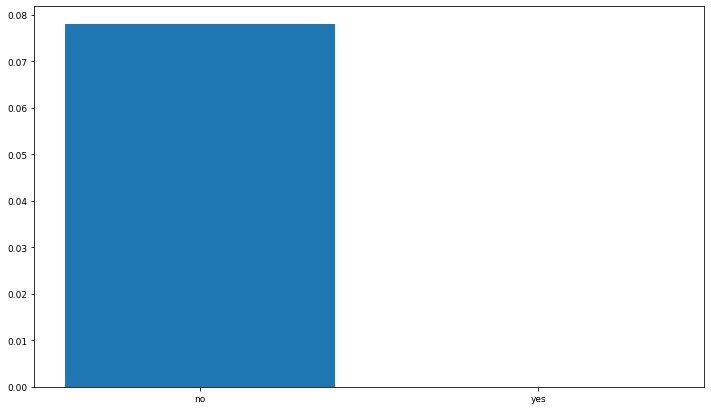

Int64Index([ -6847,  -6846,  -6843,  -6841,  -6839,  -6834,  -6824,  -6817,
             -6814,  -6806,
            ...
            102090, 102091, 102100, 102101, 102105, 102110, 102115, 102116,
            102117, 102121],
           dtype='int64', length=23967)
balance とキャンペーン参加人数の関係


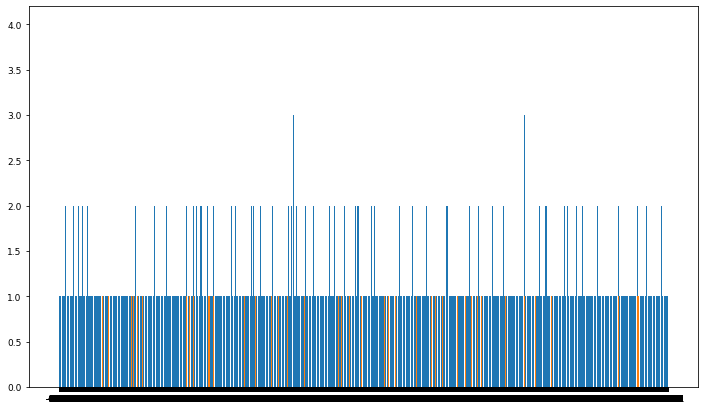

balance とキャンペーン参加率の関係


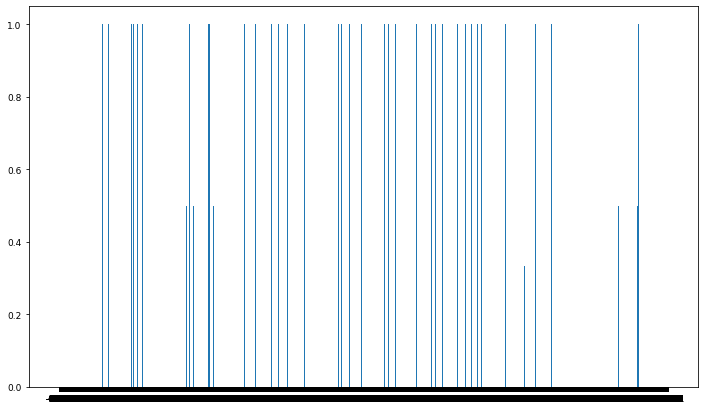

Index(['no', 'yes'], dtype='object')
housing とキャンペーン参加人数の関係


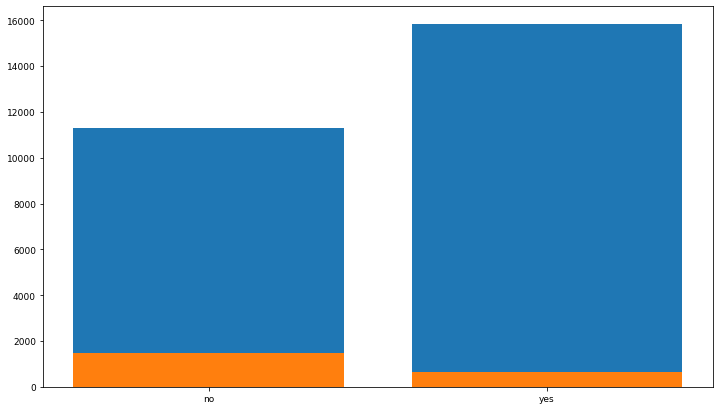

housing とキャンペーン参加率の関係


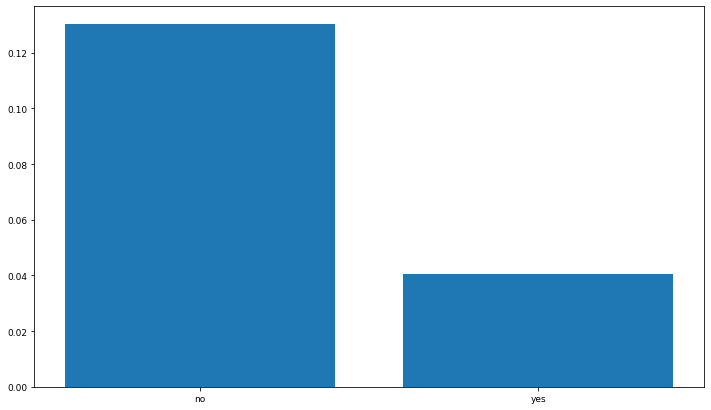

Index(['no', 'yes'], dtype='object')
loan とキャンペーン参加人数の関係


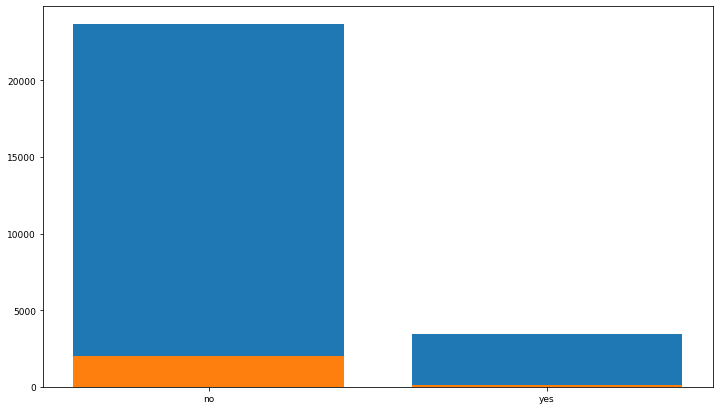

loan とキャンペーン参加率の関係


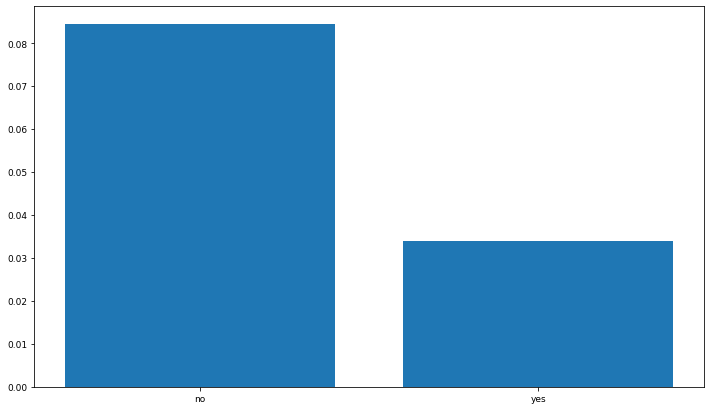

Index(['cellular', 'telephone', 'unknown'], dtype='object')
contact とキャンペーン参加人数の関係


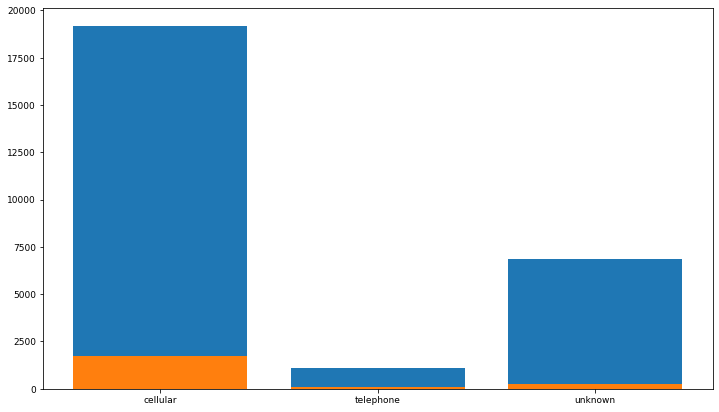

contact とキャンペーン参加率の関係


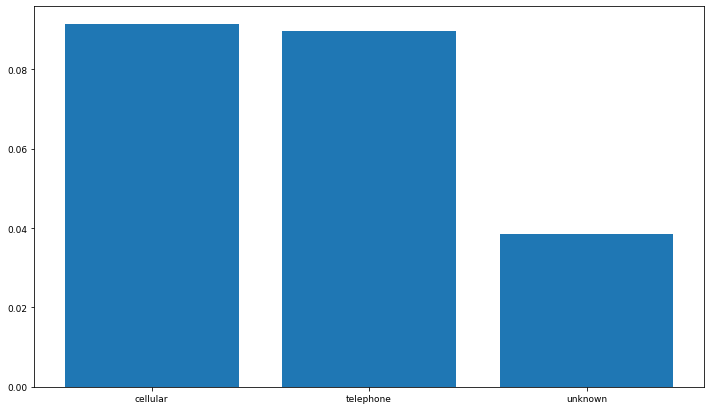

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64')
day とキャンペーン参加人数の関係


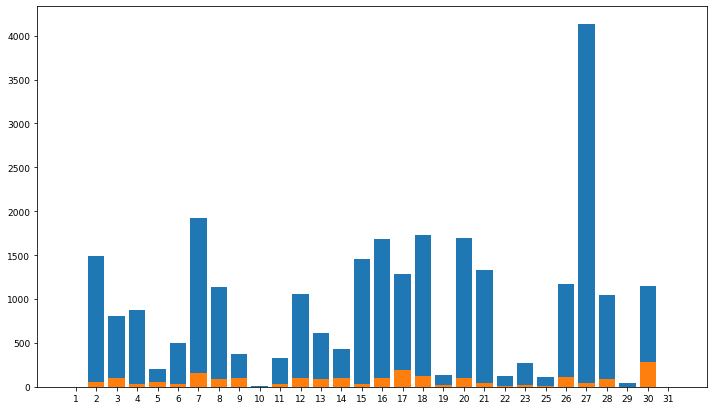

day とキャンペーン参加率の関係


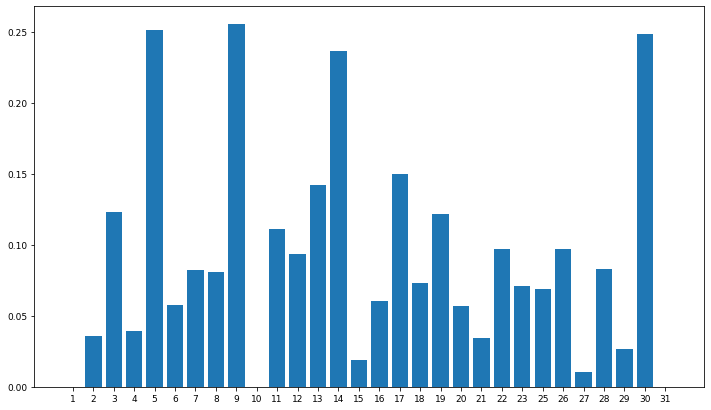

Index(['apr', 'aug', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
       'sep'],
      dtype='object')
month とキャンペーン参加人数の関係


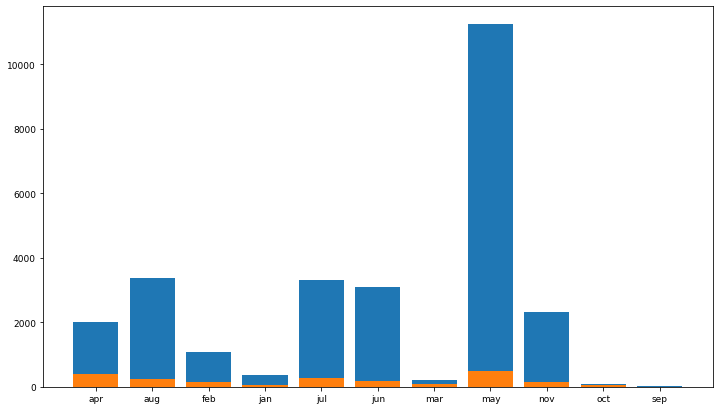

month とキャンペーン参加率の関係


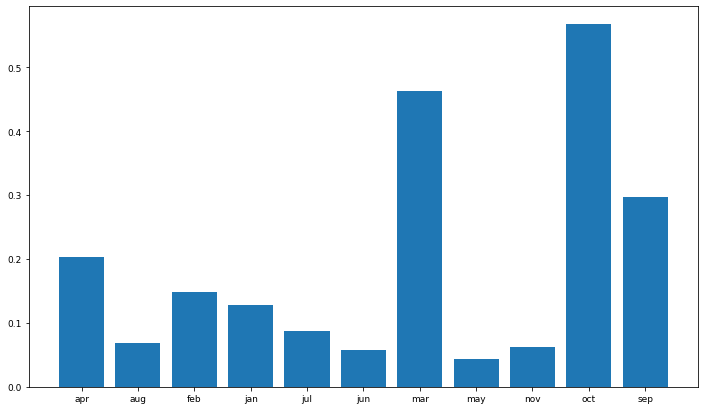

Int64Index([   0,   14,   24,   43,   47,   48,   52,   56,   58,   59,
            ...
            1133, 1182, 1220, 1319, 1337, 1347, 1388, 1447, 1579, 3076],
           dtype='int64', length=140)
duration とキャンペーン参加人数の関係


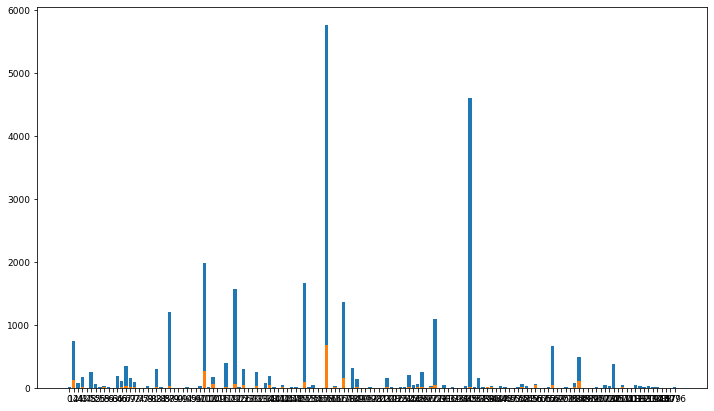

duration とキャンペーン参加率の関係


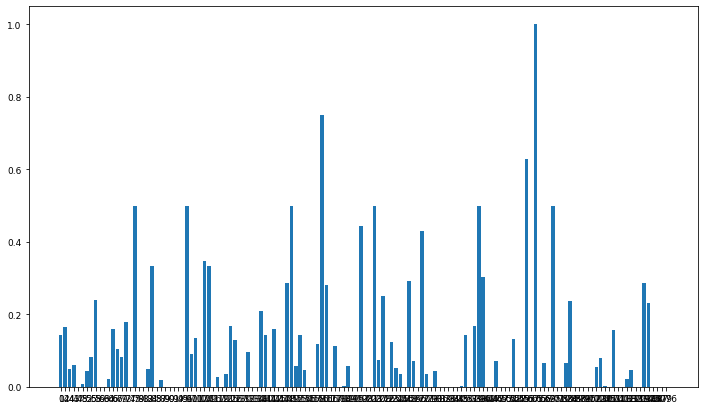

Int64Index([1, 2, 3, 4, 5], dtype='int64')
campaign とキャンペーン参加人数の関係


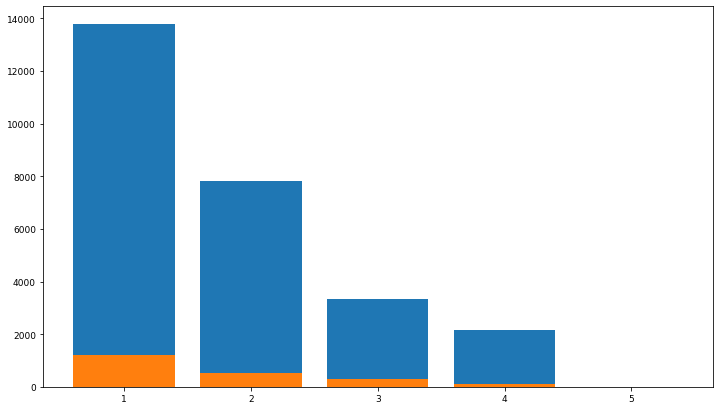

campaign とキャンペーン参加率の関係


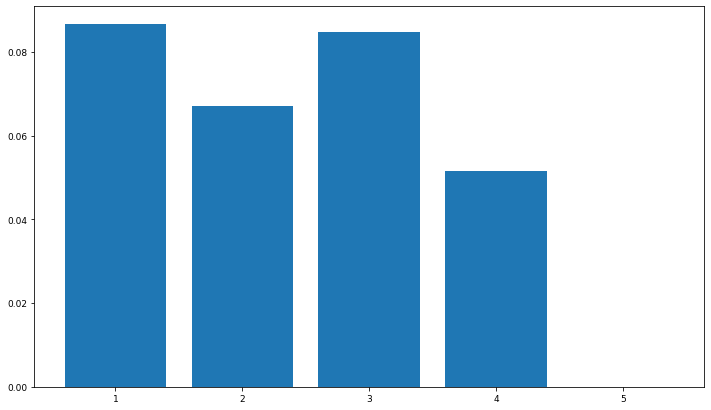

Int64Index([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
            ...
            861, 862, 863, 864, 865, 866, 867, 868, 869, 870],
           dtype='int64', length=872)
pdays とキャンペーン参加人数の関係


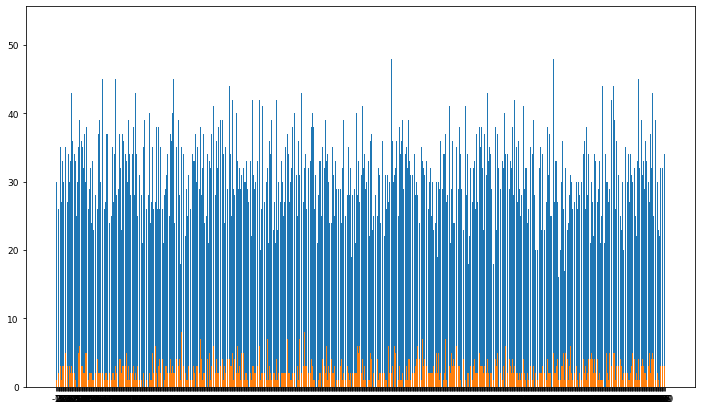

pdays とキャンペーン参加率の関係


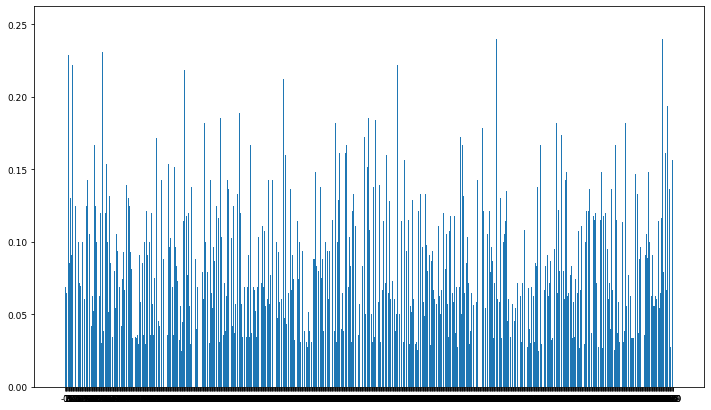

Int64Index([0, 1, 2, 3], dtype='int64')
previous とキャンペーン参加人数の関係


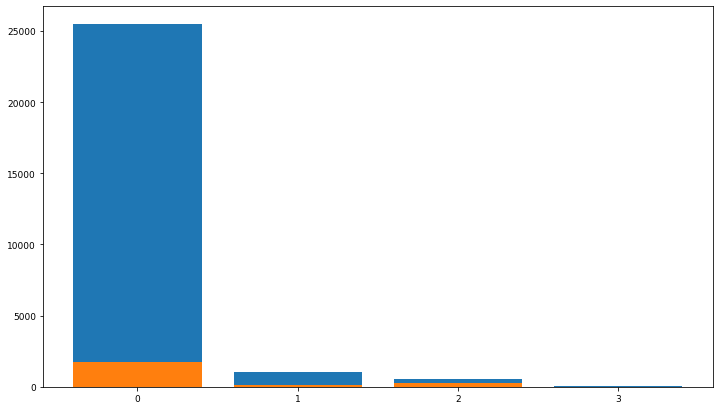

previous とキャンペーン参加率の関係


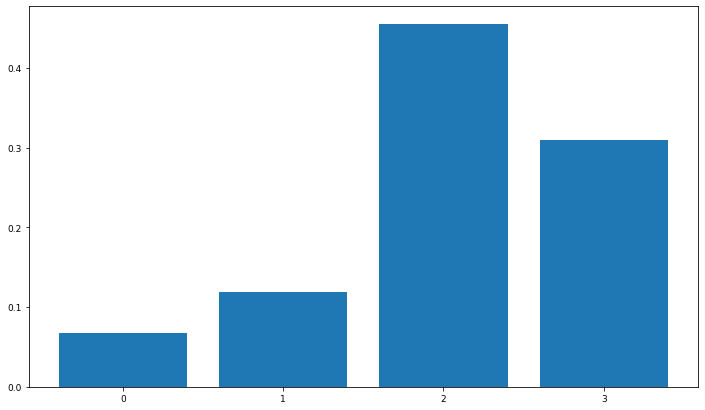

Index(['failure', 'other', 'success', 'unknown'], dtype='object')
poutcome とキャンペーン参加人数の関係


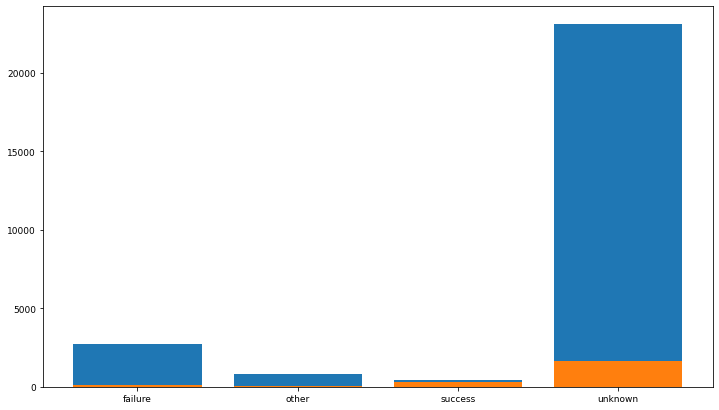

poutcome とキャンペーン参加率の関係


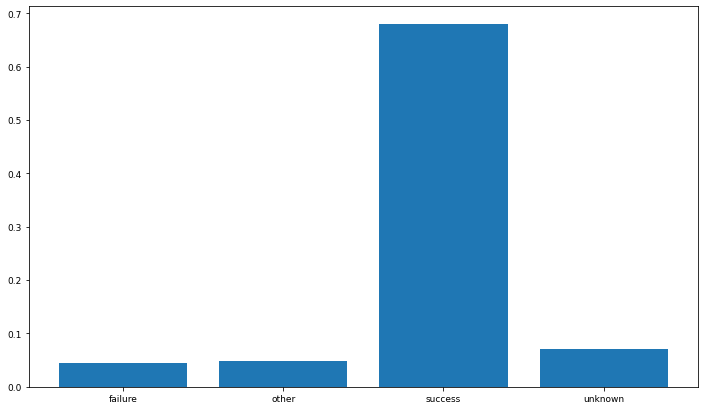

In [95]:
f_list = [ 'age', 'job', 'marital', 'education', 'default', 'housing','loan','contact', 
          'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome' ]
for f_name in f_list:
    relationship(f_name)

In [96]:
# 年齢ごとの職業など可視化

In [121]:
def relationship_age(feature):
    print("\n", feature, " の円グラフ\n")
    tmp_df = train_df
    for age_lim in range(0, int(np.ceil(max(train_df['age']))), 10):
        print("###########################")
        print("#######", age_lim, "～", age_lim+10-1)
        print("###########################")
        sort_age_series = tmp_df.query('@age_lim <= age < @age_lim+10')[feature].value_counts().sort_index()
        sort_age_y_series = tmp_df.query('(@age_lim <= age < @age_lim+10) & (y == 1)')[feature].value_counts().sort_index()
        if len(sort_age_series) != 0:
            print(age_lim, " 年代の ", feature, " の割合")
            print(sort_age_series)
            plt.pie(sort_age_series, labels=sort_age_series.index)
            plt.show()
            
            print("そのうち、申し込んだ人が所属する要素の割合")
            if(len(sort_age_y_series) != 0):
                print(sort_age_y_series)
                plt.pie(sort_age_y_series, labels=sort_age_y_series.index)
                plt.show()
            else:
                print("No data\n")
        else:
            print("No data\n")





 job  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  job  の割合
admin.           254
blue-collar      220
entrepreneur     143
housemaid         57
management       222
retired          104
self-employed    115
services          68
student           70
technician       101
unemployed        92
Name: job, dtype: int64


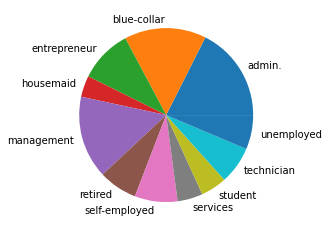

申し込んだ人の割合
admin.           27
blue-collar      29
entrepreneur     16
housemaid        10
management       41
retired          22
self-employed    12
services          6
student          30
technician       11
unemployed       16
Name: job, dtype: int64


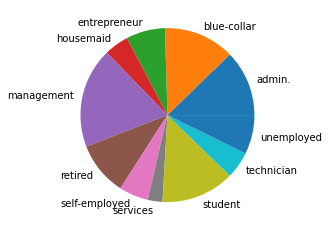

###########################
####### 30 ～ 39
###########################
30  年代の  job  の割合
admin.           2399
blue-collar      4960
entrepreneur      647
housemaid         266
management       4287
retired           174
self-employed     724
services         1983
student           226
technician       4175
unemployed        309
Name: job, dtype: int64


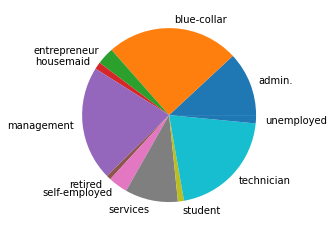

申し込んだ人の割合
admin.           191
blue-collar      240
entrepreneur      55
housemaid         12
management       306
retired           22
self-employed     61
services         104
student           50
technician       147
unemployed        39
Name: job, dtype: int64


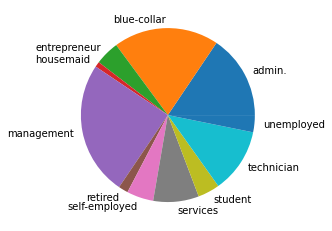

###########################
####### 40 ～ 49
###########################
40  年代の  job  の割合
admin.           400
blue-collar      555
entrepreneur     304
housemaid        294
management       479
retired          125
self-employed    261
services         322
student           19
technician       363
unemployed       255
Name: job, dtype: int64


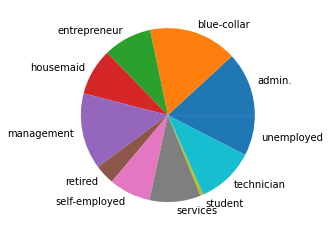

申し込んだ人の割合
admin.           43
blue-collar      49
entrepreneur     16
housemaid        29
management       44
retired          22
self-employed    25
services         39
student           7
technician       27
unemployed       22
Name: job, dtype: int64


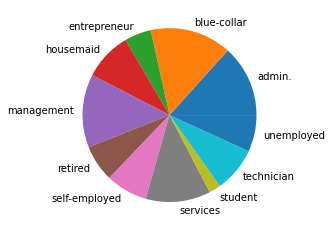

###########################
####### 50 ～ 59
###########################
50  年代の  job  の割合
admin.           114
blue-collar      163
entrepreneur      38
housemaid        117
management       253
retired          373
self-employed     50
services          91
student           11
technician       253
unemployed       105
Name: job, dtype: int64


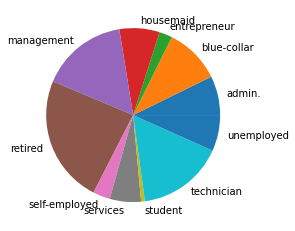

申し込んだ人の割合
admin.           10
blue-collar      14
entrepreneur      3
housemaid        12
management       48
retired          40
self-employed     6
services         13
student           2
technician       23
unemployed       14
Name: job, dtype: int64


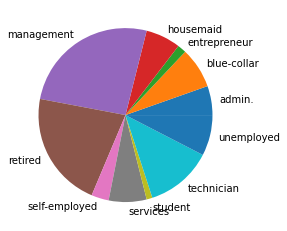

###########################
####### 60 ～ 69
###########################
60  年代の  job  の割合
admin.            20
blue-collar       59
entrepreneur      22
housemaid         20
management       105
retired          225
self-employed     13
services           5
student           27
technician        22
unemployed        34
Name: job, dtype: int64


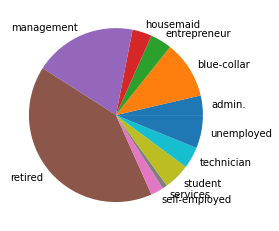

申し込んだ人の割合
admin.            5
blue-collar      13
entrepreneur      5
housemaid         5
management       24
retired          62
self-employed     8
services          1
student          15
technician        3
unemployed       16
Name: job, dtype: int64


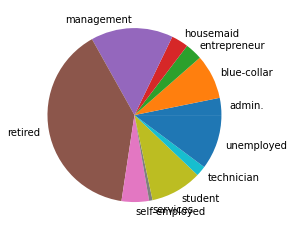

###########################
####### 70 ～ 79
###########################
70  年代の  job  の割合
retired       1
technician    1
Name: job, dtype: int64


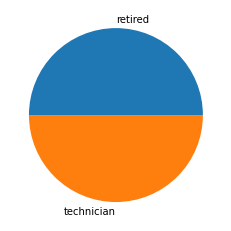

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data



In [118]:
relationship_age("job")


 job  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  job  の割合
admin.           254
blue-collar      220
entrepreneur     143
housemaid         57
management       222
retired          104
self-employed    115
services          68
student           70
technician       101
unemployed        92
Name: job, dtype: int64


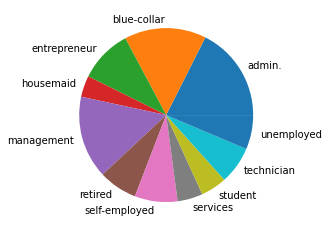

申し込んだ人の割合
admin.           27
blue-collar      29
entrepreneur     16
housemaid        10
management       41
retired          22
self-employed    12
services          6
student          30
technician       11
unemployed       16
Name: job, dtype: int64


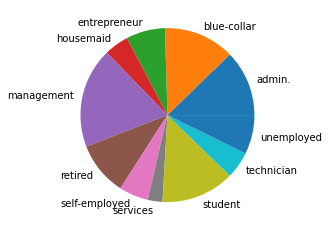

###########################
####### 30 ～ 39
###########################
30  年代の  job  の割合
admin.           2399
blue-collar      4960
entrepreneur      647
housemaid         266
management       4287
retired           174
self-employed     724
services         1983
student           226
technician       4175
unemployed        309
Name: job, dtype: int64


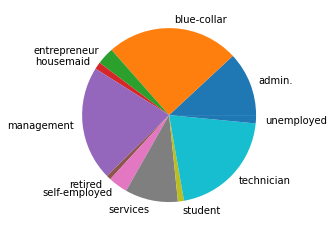

申し込んだ人の割合
admin.           191
blue-collar      240
entrepreneur      55
housemaid         12
management       306
retired           22
self-employed     61
services         104
student           50
technician       147
unemployed        39
Name: job, dtype: int64


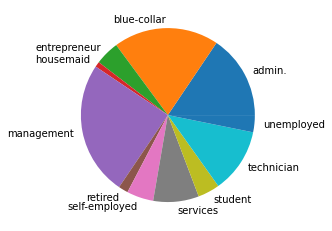

###########################
####### 40 ～ 49
###########################
40  年代の  job  の割合
admin.           400
blue-collar      555
entrepreneur     304
housemaid        294
management       479
retired          125
self-employed    261
services         322
student           19
technician       363
unemployed       255
Name: job, dtype: int64


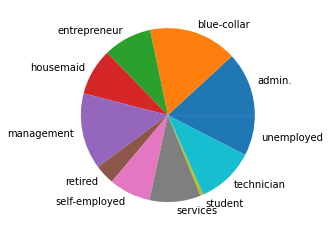

申し込んだ人の割合
admin.           43
blue-collar      49
entrepreneur     16
housemaid        29
management       44
retired          22
self-employed    25
services         39
student           7
technician       27
unemployed       22
Name: job, dtype: int64


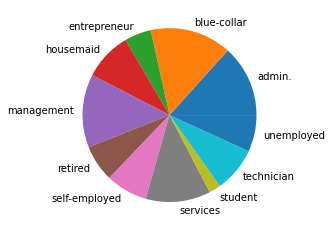

###########################
####### 50 ～ 59
###########################
50  年代の  job  の割合
admin.           114
blue-collar      163
entrepreneur      38
housemaid        117
management       253
retired          373
self-employed     50
services          91
student           11
technician       253
unemployed       105
Name: job, dtype: int64


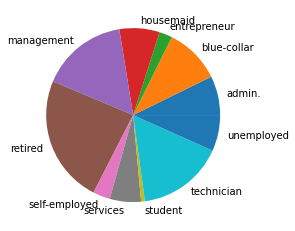

申し込んだ人の割合
admin.           10
blue-collar      14
entrepreneur      3
housemaid        12
management       48
retired          40
self-employed     6
services         13
student           2
technician       23
unemployed       14
Name: job, dtype: int64


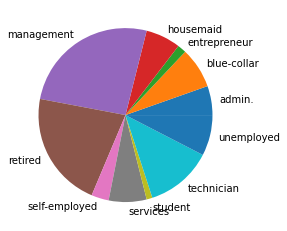

###########################
####### 60 ～ 69
###########################
60  年代の  job  の割合
admin.            20
blue-collar       59
entrepreneur      22
housemaid         20
management       105
retired          225
self-employed     13
services           5
student           27
technician        22
unemployed        34
Name: job, dtype: int64


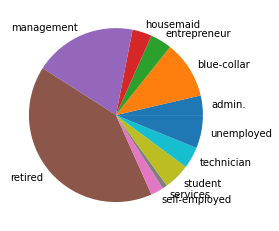

申し込んだ人の割合
admin.            5
blue-collar      13
entrepreneur      5
housemaid         5
management       24
retired          62
self-employed     8
services          1
student          15
technician        3
unemployed       16
Name: job, dtype: int64


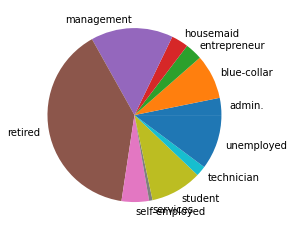

###########################
####### 70 ～ 79
###########################
70  年代の  job  の割合
retired       1
technician    1
Name: job, dtype: int64


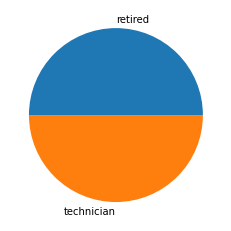

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 marital  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  marital  の割合
divorced     39
married     869
single      538
Name: marital, dtype: int64


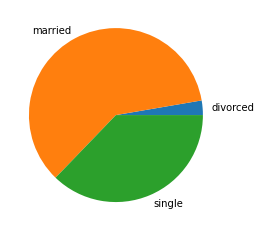

申し込んだ人の割合
divorced      3
married     119
single       98
Name: marital, dtype: int64


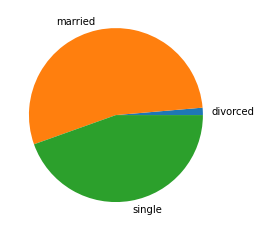

###########################
####### 30 ～ 39
###########################
30  年代の  marital  の割合
divorced     1578
married     12638
single       5934
Name: marital, dtype: int64


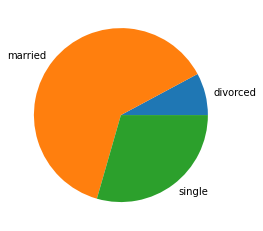

申し込んだ人の割合
divorced     71
married     538
single      618
Name: marital, dtype: int64


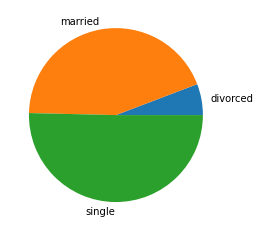

###########################
####### 40 ～ 49
###########################
40  年代の  marital  の割合
divorced     407
married     2676
single       294
Name: marital, dtype: int64


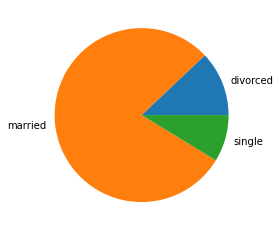

申し込んだ人の割合
divorced     34
married     244
single       45
Name: marital, dtype: int64


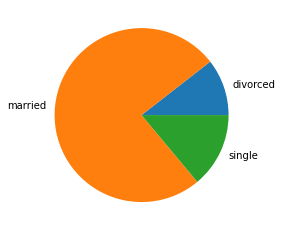

###########################
####### 50 ～ 59
###########################
50  年代の  marital  の割合
divorced     355
married     1043
single       170
Name: marital, dtype: int64


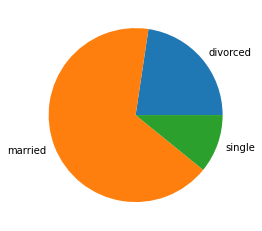

申し込んだ人の割合
divorced     38
married     105
single       42
Name: marital, dtype: int64


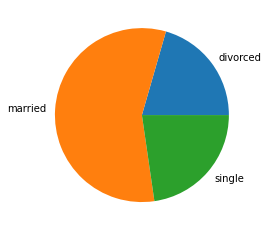

###########################
####### 60 ～ 69
###########################
60  年代の  marital  の割合
divorced     52
married     336
single      164
Name: marital, dtype: int64


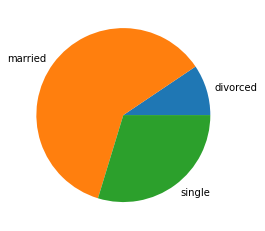

申し込んだ人の割合
divorced    11
married     92
single      54
Name: marital, dtype: int64


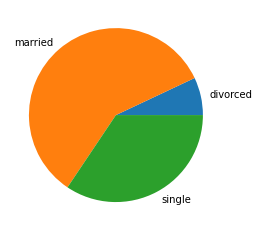

###########################
####### 70 ～ 79
###########################
70  年代の  marital  の割合
divorced    2
Name: marital, dtype: int64


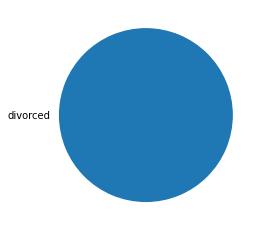

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 education  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  education  の割合
primary      168
secondary    752
tertiary     373
unknown      153
Name: education, dtype: int64


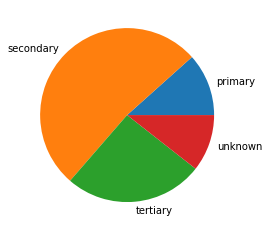

申し込んだ人の割合
primary       18
secondary    103
tertiary      66
unknown       33
Name: education, dtype: int64


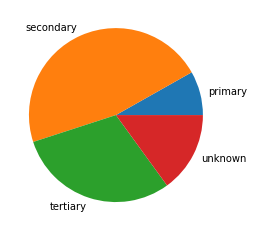

###########################
####### 30 ～ 39
###########################
30  年代の  education  の割合
primary       1812
secondary    12744
tertiary      5078
unknown        516
Name: education, dtype: int64


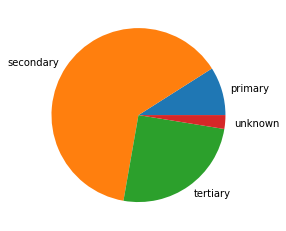

申し込んだ人の割合
primary       78
secondary    633
tertiary     454
unknown       62
Name: education, dtype: int64


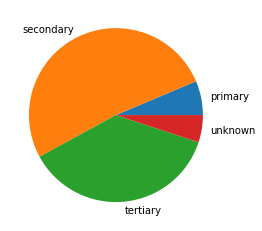

###########################
####### 40 ～ 49
###########################
40  年代の  education  の割合
primary       758
secondary    1546
tertiary      790
unknown       283
Name: education, dtype: int64


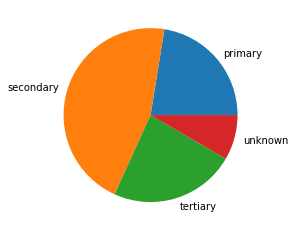

申し込んだ人の割合
primary       62
secondary    137
tertiary      81
unknown       43
Name: education, dtype: int64


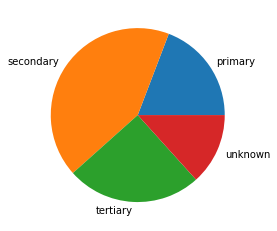

###########################
####### 50 ～ 59
###########################
50  年代の  education  の割合
primary      478
secondary    697
tertiary     332
unknown       61
Name: education, dtype: int64


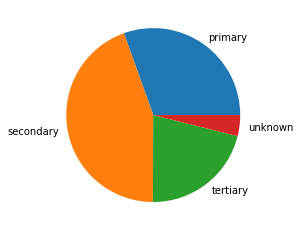

申し込んだ人の割合
primary      29
secondary    96
tertiary     55
unknown       5
Name: education, dtype: int64


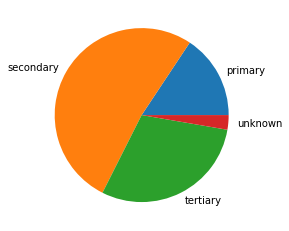

###########################
####### 60 ～ 69
###########################
60  年代の  education  の割合
primary      111
secondary    211
tertiary     164
unknown       66
Name: education, dtype: int64


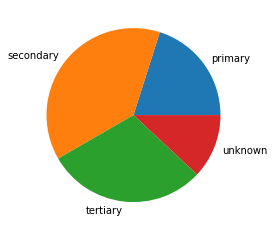

申し込んだ人の割合
primary      30
secondary    58
tertiary     48
unknown      21
Name: education, dtype: int64


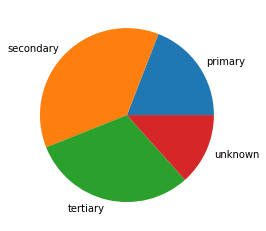

###########################
####### 70 ～ 79
###########################
70  年代の  education  の割合
primary      1
secondary    1
Name: education, dtype: int64


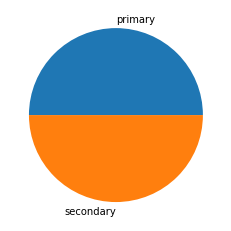

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 default  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  default  の割合
no     1445
yes       1
Name: default, dtype: int64


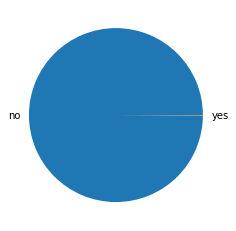

申し込んだ人の割合
no    220
Name: default, dtype: int64


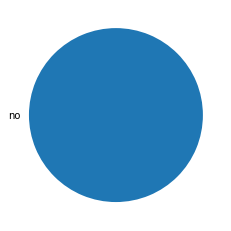

###########################
####### 30 ～ 39
###########################
30  年代の  default  の割合
no     20142
yes        8
Name: default, dtype: int64


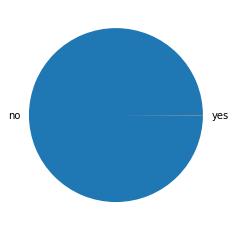

申し込んだ人の割合
no    1227
Name: default, dtype: int64


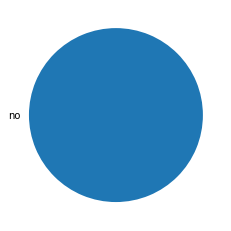

###########################
####### 40 ～ 49
###########################
40  年代の  default  の割合
no     3376
yes       1
Name: default, dtype: int64


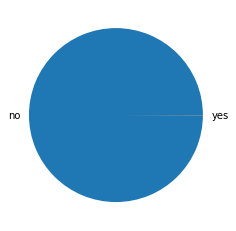

申し込んだ人の割合
no    323
Name: default, dtype: int64


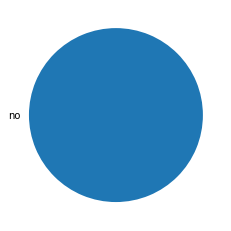

###########################
####### 50 ～ 59
###########################
50  年代の  default  の割合
no    1568
Name: default, dtype: int64


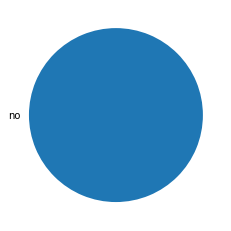

申し込んだ人の割合
no    185
Name: default, dtype: int64


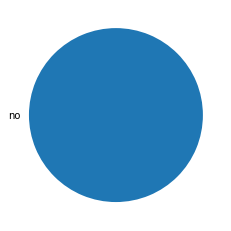

###########################
####### 60 ～ 69
###########################
60  年代の  default  の割合
no    552
Name: default, dtype: int64


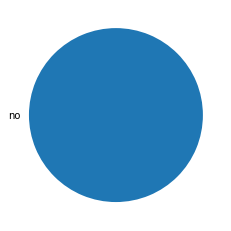

申し込んだ人の割合
no    157
Name: default, dtype: int64


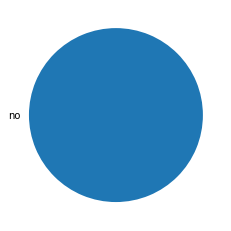

###########################
####### 70 ～ 79
###########################
70  年代の  default  の割合
no    2
Name: default, dtype: int64


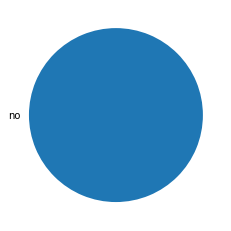

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 housing  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  housing  の割合
no     784
yes    662
Name: housing, dtype: int64


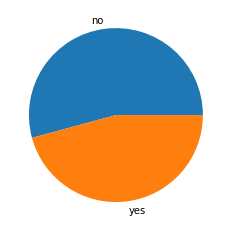

申し込んだ人の割合
no     171
yes     49
Name: housing, dtype: int64


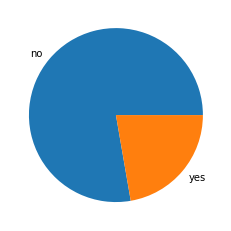

###########################
####### 30 ～ 39
###########################
30  年代の  housing  の割合
no      6520
yes    13630
Name: housing, dtype: int64


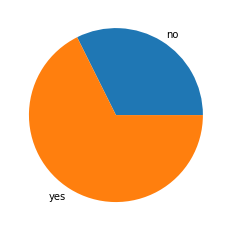

申し込んだ人の割合
no     737
yes    490
Name: housing, dtype: int64


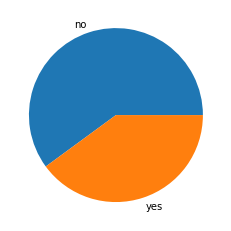

###########################
####### 40 ～ 49
###########################
40  年代の  housing  の割合
no     2267
yes    1110
Name: housing, dtype: int64


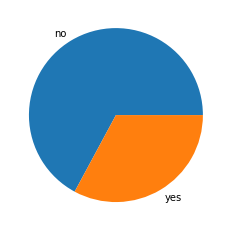

申し込んだ人の割合
no     254
yes     69
Name: housing, dtype: int64


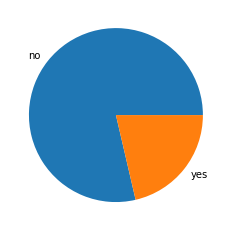

###########################
####### 50 ～ 59
###########################
50  年代の  housing  の割合
no     1278
yes     290
Name: housing, dtype: int64


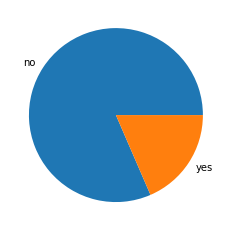

申し込んだ人の割合
no     166
yes     19
Name: housing, dtype: int64


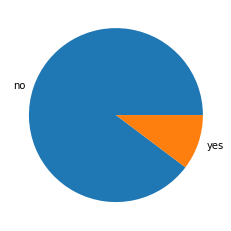

###########################
####### 60 ～ 69
###########################
60  年代の  housing  の割合
no     429
yes    123
Name: housing, dtype: int64


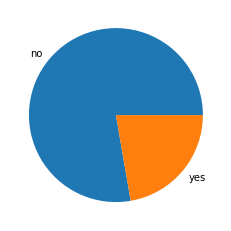

申し込んだ人の割合
no     141
yes     16
Name: housing, dtype: int64


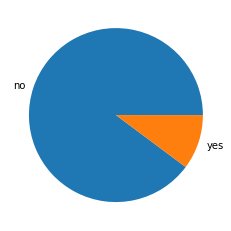

###########################
####### 70 ～ 79
###########################
70  年代の  housing  の割合
no     1
yes    1
Name: housing, dtype: int64


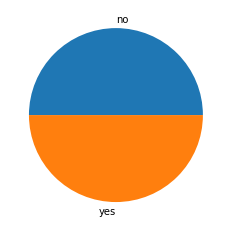

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 loan  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  loan  の割合
no     1247
yes     199
Name: loan, dtype: int64


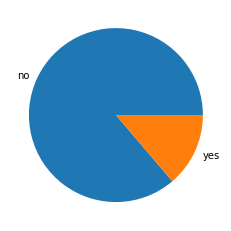

申し込んだ人の割合
no     200
yes     20
Name: loan, dtype: int64


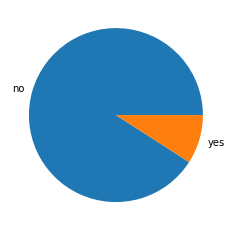

###########################
####### 30 ～ 39
###########################
30  年代の  loan  の割合
no     17640
yes     2510
Name: loan, dtype: int64


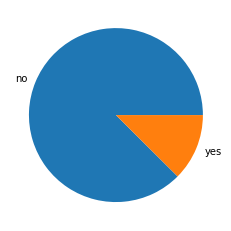

申し込んだ人の割合
no     1151
yes      76
Name: loan, dtype: int64


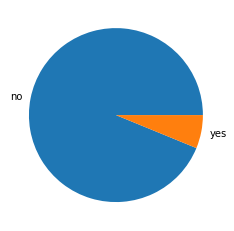

###########################
####### 40 ～ 49
###########################
40  年代の  loan  の割合
no     2866
yes     511
Name: loan, dtype: int64


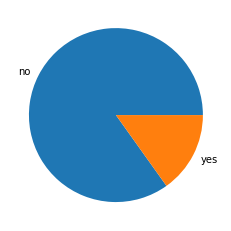

申し込んだ人の割合
no     312
yes     11
Name: loan, dtype: int64


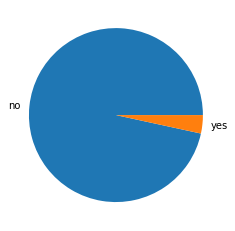

###########################
####### 50 ～ 59
###########################
50  年代の  loan  の割合
no     1353
yes     215
Name: loan, dtype: int64


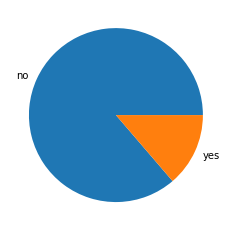

申し込んだ人の割合
no     175
yes     10
Name: loan, dtype: int64


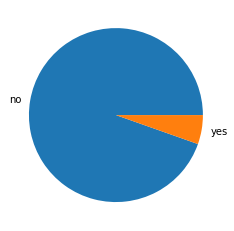

###########################
####### 60 ～ 69
###########################
60  年代の  loan  の割合
no     538
yes     14
Name: loan, dtype: int64


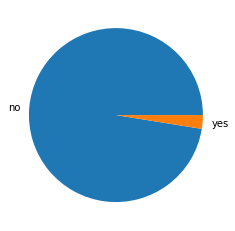

申し込んだ人の割合
no    157
Name: loan, dtype: int64


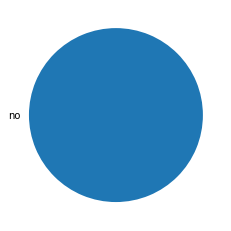

###########################
####### 70 ～ 79
###########################
70  年代の  loan  の割合
no    2
Name: loan, dtype: int64


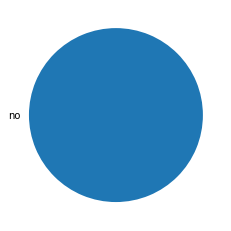

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 contact  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  contact  の割合
cellular     900
telephone    146
unknown      400
Name: contact, dtype: int64


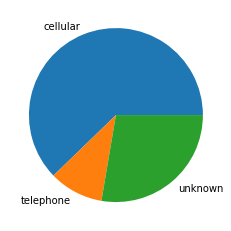

申し込んだ人の割合
cellular     168
telephone     22
unknown       30
Name: contact, dtype: int64


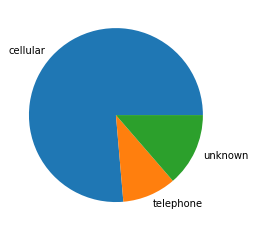

###########################
####### 30 ～ 39
###########################
30  年代の  contact  の割合
cellular     14186
telephone      516
unknown       5448
Name: contact, dtype: int64


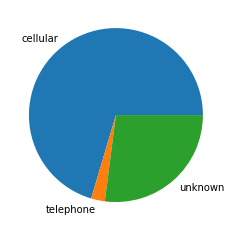

申し込んだ人の割合
cellular     1001
telephone      39
unknown       187
Name: contact, dtype: int64


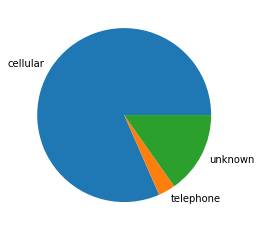

###########################
####### 40 ～ 49
###########################
40  年代の  contact  の割合
cellular     2493
telephone     307
unknown       577
Name: contact, dtype: int64


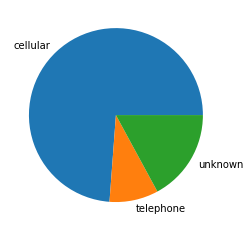

申し込んだ人の割合
cellular     278
telephone     21
unknown       24
Name: contact, dtype: int64


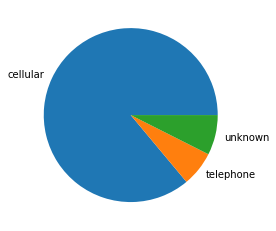

###########################
####### 50 ～ 59
###########################
50  年代の  contact  の割合
cellular     1139
telephone     108
unknown       321
Name: contact, dtype: int64


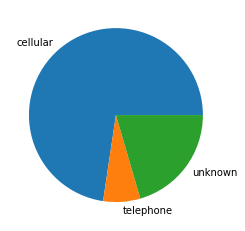

申し込んだ人の割合
cellular     160
telephone     12
unknown       13
Name: contact, dtype: int64


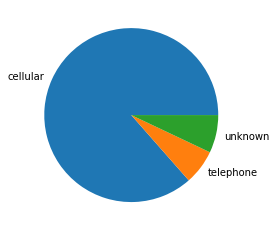

###########################
####### 60 ～ 69
###########################
60  年代の  contact  の割合
cellular     428
telephone     27
unknown       97
Name: contact, dtype: int64


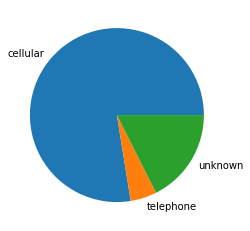

申し込んだ人の割合
cellular     142
telephone      5
unknown       10
Name: contact, dtype: int64


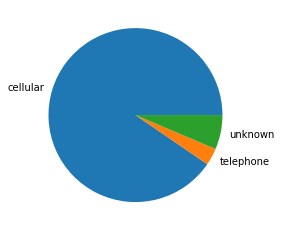

###########################
####### 70 ～ 79
###########################
70  年代の  contact  の割合
cellular    1
unknown     1
Name: contact, dtype: int64


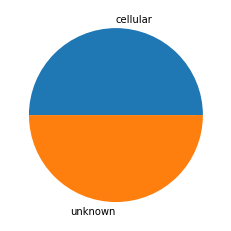

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 day  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  day  の割合
2      54
3      47
4      30
5      16
6      36
7     163
8      42
9      26
11     10
12     54
13     48
14     56
15     38
16    150
17     86
18     30
19      9
20     56
21     48
22      7
23      9
25     12
26     97
27    172
28     65
29      4
30     81
Name: day, dtype: int64


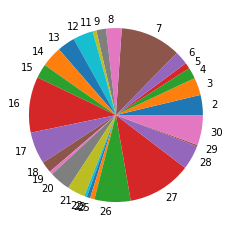

申し込んだ人の割合
2      6
3     11
5      4
6      5
7     30
8      6
9      7
11     1
12     7
13    11
14    21
15     2
16    16
17    24
18     5
19     1
20     5
21     1
22     1
23     1
25     3
26    13
27     8
28     8
30    23
Name: day, dtype: int64


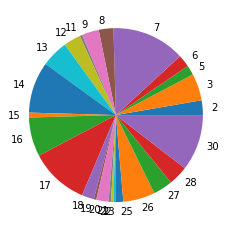

###########################
####### 30 ～ 39
###########################
30  年代の  day  の割合
1        1
2     1185
3      562
4      603
5      136
6      339
7     1276
8      878
9      180
10       1
11     227
12     814
13     330
14     188
15    1301
16    1297
17     871
18    1296
19      61
20    1289
21     859
22      67
23     219
25      84
26     824
27    3798
28     753
29      22
30     687
31       2
Name: day, dtype: int64


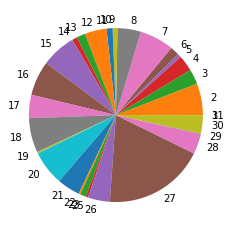

申し込んだ人の割合
2      35
3      71
4      26
5      28
6      21
7      82
8      51
9      47
11     21
12     58
13     43
14     38
15     16
16     67
17    116
18     93
19      7
20     62
21     27
22      5
23     13
25      3
26     56
27     27
28     55
29      1
30    158
Name: day, dtype: int64


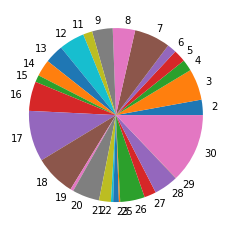

###########################
####### 40 ～ 49
###########################
40  年代の  day  の割合
2     135
3     146
4     150
5      27
6      86
7     279
8     119
9      99
11     47
12    139
13    140
14    107
15     81
16    158
17    216
18    196
19     39
20    189
21    328
22     22
23     19
25      6
26    156
27    103
28    159
29      6
30    224
31      1
Name: day, dtype: int64


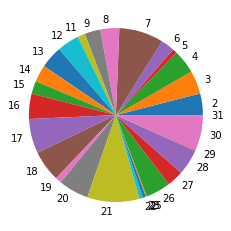

申し込んだ人の割合
2      7
3     10
4      6
5      8
6      1
7     17
8     15
9     16
11     5
12    22
13    17
14    19
15     7
16     9
17    30
18    12
19     3
20    16
21    12
22     3
23     2
26    27
27     4
28    13
30    42
Name: day, dtype: int64


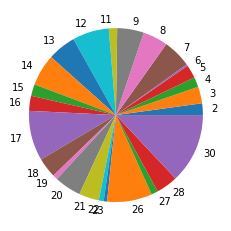

###########################
####### 50 ～ 59
###########################
50  年代の  day  の割合
2     102
3      35
4      86
5      13
6      20
7     132
8      72
9      49
10      2
11     29
12     27
13     74
14     51
15     20
16     42
17     76
18    200
19     28
20    137
21     85
22     28
23     12
25     10
26     69
27     46
28     46
29      5
30     72
Name: day, dtype: int64


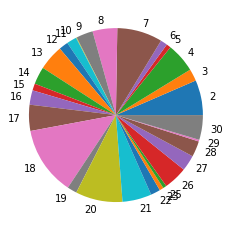

申し込んだ人の割合
2      3
3      6
4      2
5      8
6      1
7     17
8     13
9     13
11     5
12     6
13    11
14    11
16     5
17    11
18    17
19     6
20     8
21     6
22     3
26     7
27     2
28     3
30    21
Name: day, dtype: int64


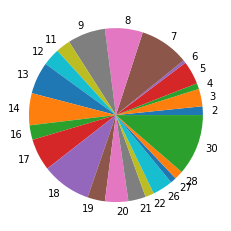

###########################
####### 60 ～ 69
###########################
60  年代の  day  の割合
2     18
3     15
4      3
5      7
6     21
7     69
8     31
9     22
10     1
11    11
12    26
13    26
14    33
15    11
16    34
17    36
18    10
19     3
20    22
21     8
23     8
25     4
26    23
27    10
28    21
29     1
30    78
Name: day, dtype: int64


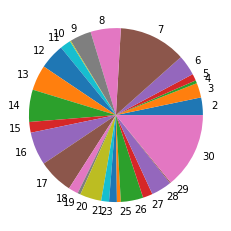

申し込んだ人の割合
2      2
3      1
5      2
6      1
7     12
8      7
9     13
11     4
12     6
13     6
14    14
15     2
16     5
17    12
20     5
23     3
25     2
26    11
27     1
28     8
30    40
Name: day, dtype: int64


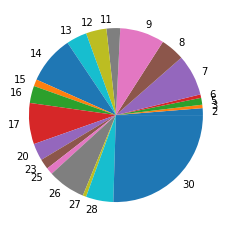

###########################
####### 70 ～ 79
###########################
70  年代の  day  の割合
3     1
26    1
Name: day, dtype: int64


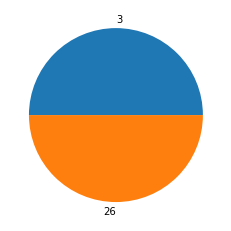

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 month  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  month  の割合
apr     90
aug     81
feb     59
jan     17
jul    337
jun    144
mar     23
may    601
nov     85
oct      6
sep      3
Name: month, dtype: int64


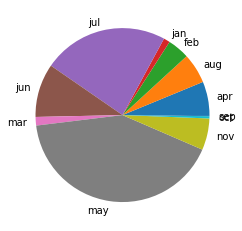

申し込んだ人の割合
apr    42
aug    15
feb    10
jan     2
jul    50
jun    22
mar    13
may    53
nov     7
oct     5
sep     1
Name: month, dtype: int64


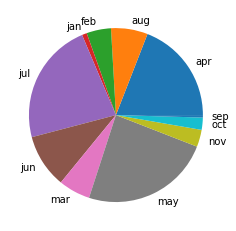

###########################
####### 30 ～ 39
###########################
30  年代の  month  の割合
apr    1533
aug    2132
feb     691
jan     257
jul    2015
jun    2235
mar      90
may    9582
nov    1546
oct      49
sep      20
Name: month, dtype: int64


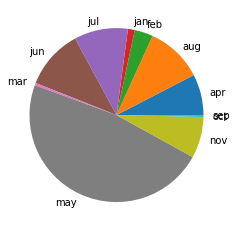

申し込んだ人の割合
apr    241
aug    119
feb    102
jan     38
jul    127
jun    105
mar     39
may    339
nov     86
oct     24
sep      7
Name: month, dtype: int64


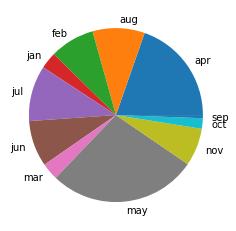

###########################
####### 40 ～ 49
###########################
40  年代の  month  の割合
apr    247
aug    629
feb    258
jan     67
jul    596
jun    380
mar     46
may    634
nov    500
oct     17
sep      3
Name: month, dtype: int64


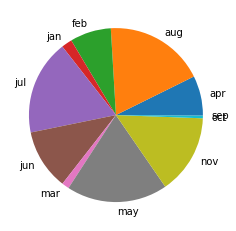

申し込んだ人の割合
apr    70
aug    42
feb    36
jan     4
jul    44
jun    20
mar    20
may    46
nov    31
oct    10
Name: month, dtype: int64


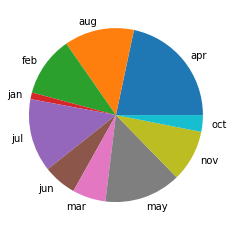

###########################
####### 50 ～ 59
###########################
50  年代の  month  の割合
apr     72
aug    501
feb     59
jan      8
jul    248
jun    253
mar     24
may    246
nov    151
oct      5
sep      1
Name: month, dtype: int64


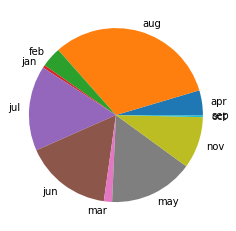

申し込んだ人の割合
apr    28
aug    46
feb    12
jan     1
jul    33
jun    12
mar    11
may    23
nov    15
oct     4
Name: month, dtype: int64


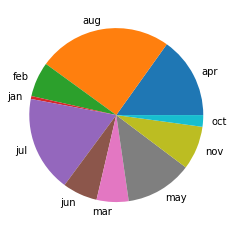

###########################
####### 60 ～ 69
###########################
60  年代の  month  の割合
apr     62
aug     38
feb     16
jan     12
jul    111
jun     73
mar     31
may    164
nov     25
oct     20
Name: month, dtype: int64


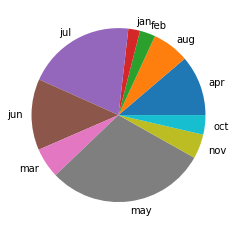

申し込んだ人の割合
apr    27
aug     9
feb     1
jan     1
jul    33
jun    17
mar    16
may    35
nov     6
oct    12
Name: month, dtype: int64


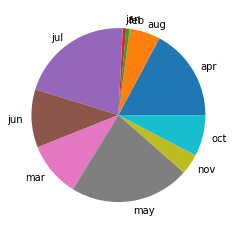

###########################
####### 70 ～ 79
###########################
70  年代の  month  の割合
apr    1
may    1
Name: month, dtype: int64


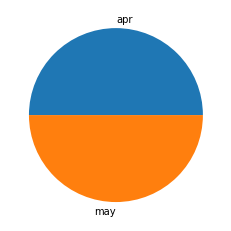

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 duration  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  duration  の割合
14       53
43       23
48        2
52        5
58        3
64       11
66       27
67       31
69       14
72        3
82        9
87       16
89        2
97        1
101      79
104      16
117      14
121      81
126      17
132       5
134       1
138      10
142       6
145       1
152     114
153       3
154       4
158     373
177      95
184       1
189       4
207       8
208       1
245      18
246       4
248       9
259      17
270       1
271      76
319       1
340       1
345     180
351       1
379       2
396       2
518       3
555      10
605       1
612       1
658      25
755       9
826      39
85

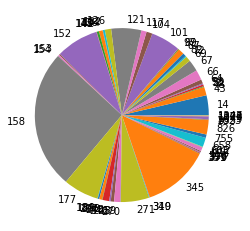

申し込んだ人の割合
14     12
43      3
58      1
66      3
67      7
69      5
72      1
87      1
101    23
104     7
121     9
126     2
132     3
138     3
152     5
154     1
158    71
177    20
245     5
248     1
259     2
270     1
271     8
345     1
379     1
396     1
555     8
605     1
658     3
755     1
826    10
Name: duration, dtype: int64


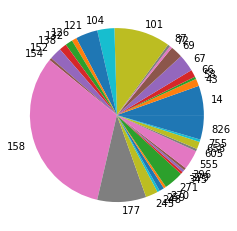

###########################
####### 30 ～ 39
###########################
30  年代の  duration  の割合
0        12
14      416
24       60
43       87
47        3
       ... 
1347      6
1388      2
1447      1
1579      1
3076      5
Name: duration, Length: 133, dtype: int64


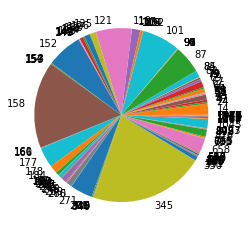

申し込んだ人の割合
0        2
14      64
24       2
43       5
48       1
        ..
826     64
1023     1
1074     7
1182     1
1337     1
Name: duration, Length: 63, dtype: int64


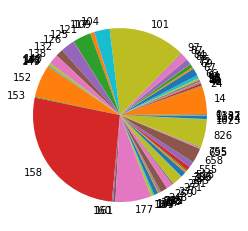

###########################
####### 40 ～ 49
###########################
40  年代の  duration  の割合
0         1
14      187
24       12
43       39
48       26
       ... 
1100      1
1133      6
1319      4
1337      3
1579      1
Name: duration, Length: 77, dtype: int64


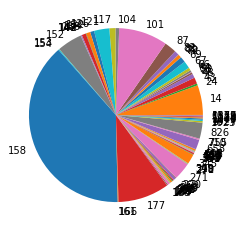

申し込んだ人の割合
14       28
24        1
43        1
66        4
67        7
69        4
72        5
82        1
87        3
101      33
104       8
121       1
126       3
132       2
138       8
152      10
158     135
161       2
177      29
189       1
248       1
259       1
270       1
271       3
350       2
396       1
555       7
605       1
658       2
826      15
1023      1
1027      1
1337      1
Name: duration, dtype: int64


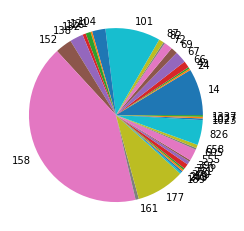

###########################
####### 50 ～ 59
###########################
50  年代の  duration  の割合
0        1
14      63
24       3
43      16
48      38
        ..
1074     3
1100     1
1133     5
1319     1
1347     3
Name: duration, Length: 69, dtype: int64


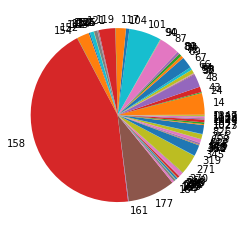

申し込んだ人の割合
14      11
43       1
48       1
66       1
67       3
72       3
82       1
84       1
101     18
104      3
117      1
121      2
132      3
138      1
142      1
152      3
154      1
158     90
177     12
189      2
197      1
203      1
270      1
271      3
388      1
443      1
555      5
658      2
826      9
1347     2
Name: duration, dtype: int64


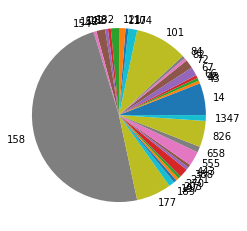

###########################
####### 60 ～ 69
###########################
60  年代の  duration  の割合
14       18
24        8
43        4
48        2
52        1
58        1
64        1
66        6
67        5
69        3
72        2
82        3
87        7
96        1
101      88
104      11
117       4
121      10
126       7
132       4
134       2
138      10
142       4
152      26
153       1
158     134
161       3
177      43
189       1
207       6
245       5
248       3
259       6
270       2
271      13
291       1
345      16
396       4
443       1
504       1
555      11
658      11
755       3
826      48
1027      3
1045      3
1133      2
1347      3
Name: duration, dtype: int64


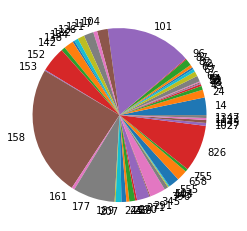

申し込んだ人の割合
14       6
24       1
52       1
66       3
67       1
72       1
87       1
96       1
101     19
104      5
117      1
121      1
126      1
138      4
142      2
152      4
158     50
161      2
177      9
207      2
248      1
259      1
270      2
271      3
291      1
396      2
555      6
658      3
755      2
826     17
1027     1
1045     1
1133     1
1347     1
Name: duration, dtype: int64


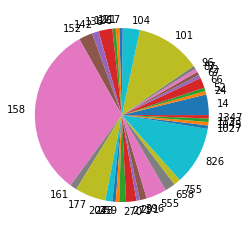

###########################
####### 70 ～ 79
###########################
70  年代の  duration  の割合
14     1
755    1
Name: duration, dtype: int64


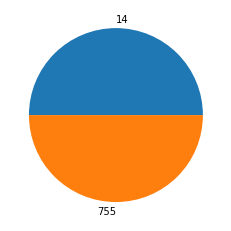

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 campaign  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  campaign  の割合
1    791
2    340
3    207
4    108
Name: campaign, dtype: int64


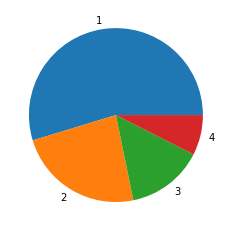

申し込んだ人の割合
1    142
2     48
3     22
4      8
Name: campaign, dtype: int64


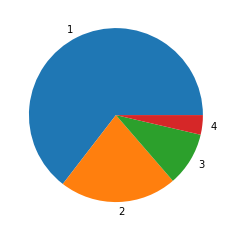

###########################
####### 30 ～ 39
###########################
30  年代の  campaign  の割合
1    10619
2     5636
3     2346
4     1548
5        1
Name: campaign, dtype: int64


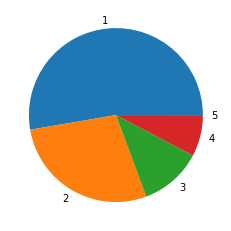

申し込んだ人の割合
1    661
2    329
3    167
4     70
Name: campaign, dtype: int64


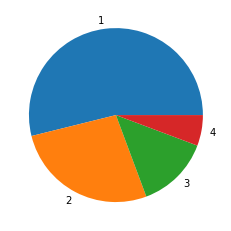

###########################
####### 40 ～ 49
###########################
40  年代の  campaign  の割合
1    1346
2    1215
3     469
4     347
Name: campaign, dtype: int64


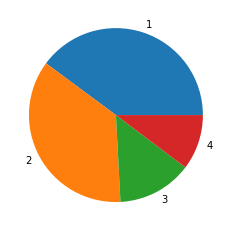

申し込んだ人の割合
1    181
2     86
3     44
4     12
Name: campaign, dtype: int64


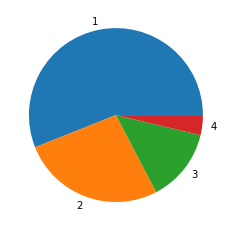

###########################
####### 50 ～ 59
###########################
50  年代の  campaign  の割合
1    649
2    528
3    234
4    157
Name: campaign, dtype: int64


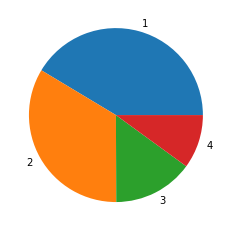

申し込んだ人の割合
1    97
2    43
3    27
4    18
Name: campaign, dtype: int64


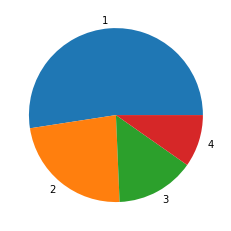

###########################
####### 60 ～ 69
###########################
60  年代の  campaign  の割合
1    360
2     93
3     83
4     16
Name: campaign, dtype: int64


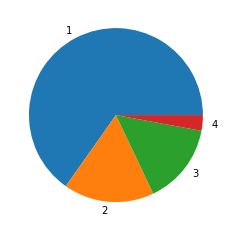

申し込んだ人の割合
1    111
2     19
3     23
4      4
Name: campaign, dtype: int64


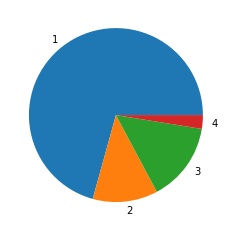

###########################
####### 70 ～ 79
###########################
70  年代の  campaign  の割合
1    1
2    1
Name: campaign, dtype: int64


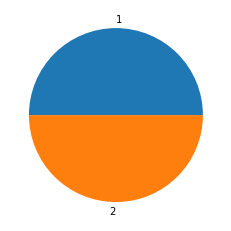

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 pdays  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  pdays  の割合
-1      2
 0      3
 2      2
 4      2
 7      4
       ..
 866    2
 867    3
 868    2
 869    3
 870    4
Name: pdays, Length: 692, dtype: int64


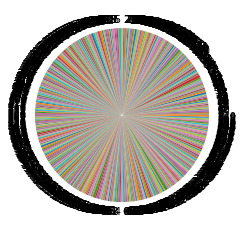

申し込んだ人の割合
2      1
7      1
32     1
38     1
40     1
      ..
859    1
865    1
867    1
869    1
870    1
Name: pdays, Length: 193, dtype: int64


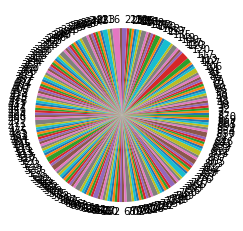

###########################
####### 30 ～ 39
###########################
30  年代の  pdays  の割合
-1      25
 0      22
 1      26
 2      16
 3      25
        ..
 866    24
 867    26
 868    22
 869    19
 870    23
Name: pdays, Length: 872, dtype: int64


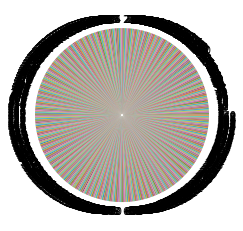

申し込んだ人の割合
-1      1
 0      2
 1      1
 2      1
 3      3
       ..
 865    1
 867    2
 868    1
 869    2
 870    1
Name: pdays, Length: 656, dtype: int64


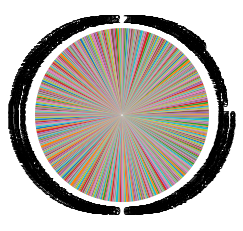

###########################
####### 40 ～ 49
###########################
40  年代の  pdays  の割合
0      4
1      1
2      5
3      4
4      8
      ..
866    7
867    3
868    3
869    8
870    2
Name: pdays, Length: 845, dtype: int64


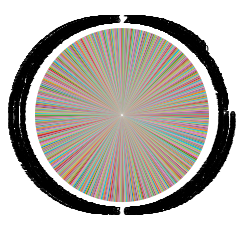

申し込んだ人の割合
3      1
4      3
5      1
9      1
18     1
      ..
857    1
862    1
865    1
868    1
869    2
Name: pdays, Length: 262, dtype: int64


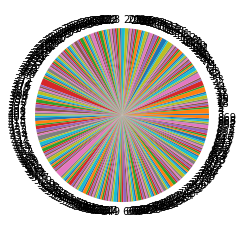

###########################
####### 50 ～ 59
###########################
50  年代の  pdays  の割合
-1      3
 1      2
 2      3
 3      2
 4      2
       ..
 865    1
 866    2
 868    1
 869    2
 870    2
Name: pdays, Length: 739, dtype: int64


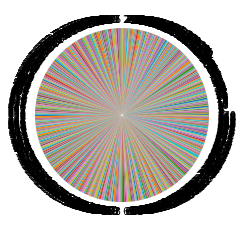

申し込んだ人の割合
7      1
10     1
12     1
30     1
38     1
      ..
856    1
859    2
862    1
864    1
866    1
Name: pdays, Length: 168, dtype: int64


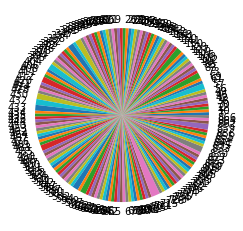

###########################
####### 60 ～ 69
###########################
60  年代の  pdays  の割合
1      2
5      1
7      3
8      1
9      1
      ..
860    2
862    1
864    1
866    1
870    3
Name: pdays, Length: 395, dtype: int64


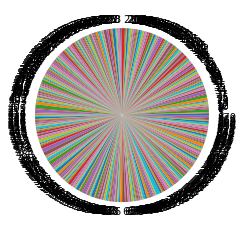

申し込んだ人の割合
1      1
5      1
7      1
8      1
10     1
      ..
855    1
856    1
858    1
860    2
870    1
Name: pdays, Length: 148, dtype: int64


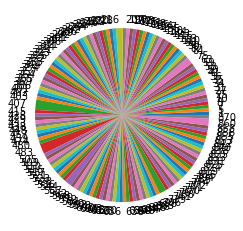

###########################
####### 70 ～ 79
###########################
70  年代の  pdays  の割合
307    1
831    1
Name: pdays, dtype: int64


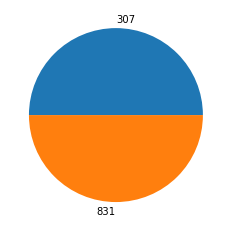

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 previous  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  previous  の割合
0    1373
1      36
2      34
3       3
Name: previous, dtype: int64


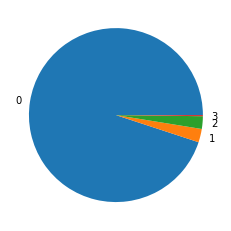

申し込んだ人の割合
0    194
1      8
2     17
3      1
Name: previous, dtype: int64


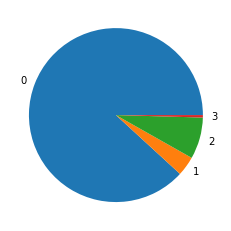

###########################
####### 30 ～ 39
###########################
30  年代の  previous  の割合
0    18949
1      807
2      362
3       32
Name: previous, dtype: int64


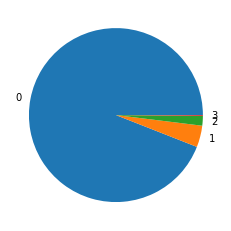

申し込んだ人の割合
0    991
1     71
2    161
3      4
Name: previous, dtype: int64


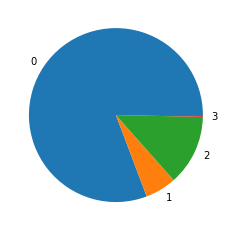

###########################
####### 40 ～ 49
###########################
40  年代の  previous  の割合
0    3177
1     121
2      66
3      13
Name: previous, dtype: int64


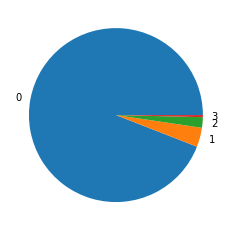

申し込んだ人の割合
0    266
1     24
2     27
3      6
Name: previous, dtype: int64


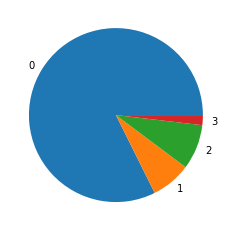

###########################
####### 50 ～ 59
###########################
50  年代の  previous  の割合
0    1496
1      31
2      36
3       5
Name: previous, dtype: int64


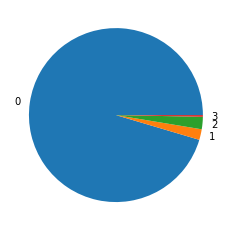

申し込んだ人の割合
0    156
1      9
2     16
3      4
Name: previous, dtype: int64


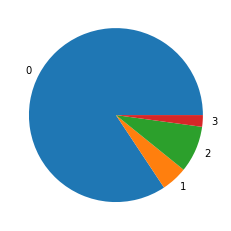

###########################
####### 60 ～ 69
###########################
60  年代の  previous  の割合
0    459
1     28
2     50
3     15
Name: previous, dtype: int64


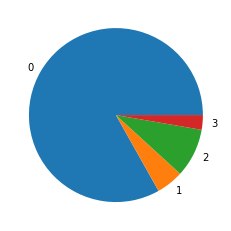

申し込んだ人の割合
0    114
1      9
2     28
3      6
Name: previous, dtype: int64


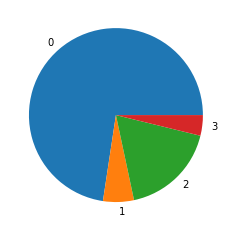

###########################
####### 70 ～ 79
###########################
70  年代の  previous  の割合
0    2
Name: previous, dtype: int64


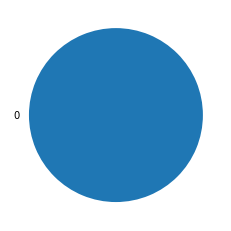

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data


 poutcome  の円グラフ

###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
20  年代の  poutcome  の割合
failure     101
other        11
success      21
unknown    1313
Name: poutcome, dtype: int64


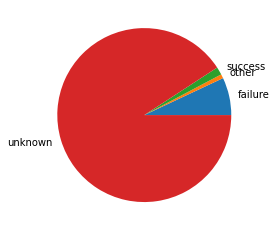

申し込んだ人の割合
failure     12
other        1
success     19
unknown    188
Name: poutcome, dtype: int64


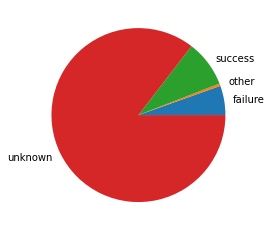

###########################
####### 30 ～ 39
###########################
30  年代の  poutcome  の割合
failure     2060
other        691
success      317
unknown    17082
Name: poutcome, dtype: int64


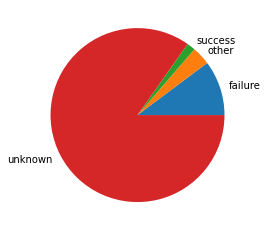

申し込んだ人の割合
failure     61
other       26
success    204
unknown    936
Name: poutcome, dtype: int64


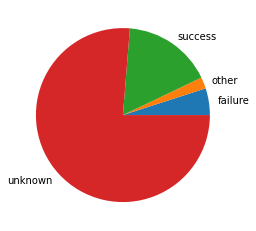

###########################
####### 40 ～ 49
###########################
40  年代の  poutcome  の割合
failure     339
other        78
success      61
unknown    2899
Name: poutcome, dtype: int64


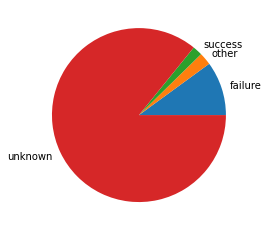

申し込んだ人の割合
failure     21
other        8
success     37
unknown    257
Name: poutcome, dtype: int64


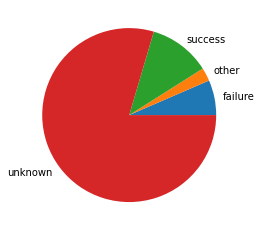

###########################
####### 50 ～ 59
###########################
50  年代の  poutcome  の割合
failure     109
other        19
success      27
unknown    1413
Name: poutcome, dtype: int64


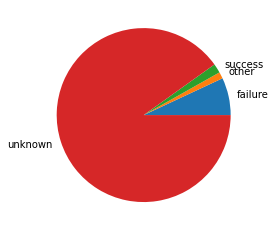

申し込んだ人の割合
failure      9
other        3
success     22
unknown    151
Name: poutcome, dtype: int64


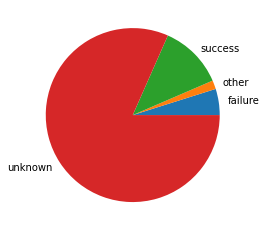

###########################
####### 60 ～ 69
###########################
60  年代の  poutcome  の割合
failure    107
other       27
success     32
unknown    386
Name: poutcome, dtype: int64


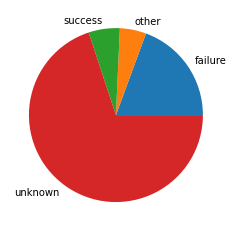

申し込んだ人の割合
failure     16
other        2
success     29
unknown    110
Name: poutcome, dtype: int64


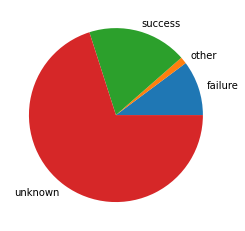

###########################
####### 70 ～ 79
###########################
70  年代の  poutcome  の割合
failure    1
unknown    1
Name: poutcome, dtype: int64


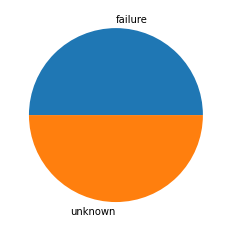

申し込んだ人の割合
No data

###########################
####### 80 ～ 89
###########################
No data



In [119]:
f_list = [ 'job', 'marital', 'education', 'default', 'housing','loan','contact', 
          'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome' ]
for f_name in f_list:
    relationship_age(f_name)

In [120]:
# 債務不履行がある人と教育の関係

In [135]:
def relationship_default(feature):
    print("\n", feature, " の円グラフ\n")
    tmp_df = train_df
    print("###########################")
    print("#######", "債務不履行がある人のうち", feature, "の割合")
    print("###########################")
    sort_default_series = tmp_df.query('default == "yes"')[feature].value_counts().sort_index()
    sort_default_y_series = tmp_df.query('(default == "yes") & (y == 1)')[feature].value_counts().sort_index()
    print(sort_default_series)
    if len(sort_default_series) != 0:
        plt.pie(sort_default_series, labels=sort_default_series.index)
        plt.show()
            
        print("そのうち、申し込んだ人が所属する要素の割合")
        if(len(sort_default_y_series) != 0):
            print(sort_default_y_series)
            plt.pie(sort_default_y_series, labels=sort_default_y_series.index)
            plt.show()
        else:
            print("No data\n")
    else:
        print("No data\n")





 education  の円グラフ

###########################
####### 債務不履行がある人のうち education の割合
###########################
primary      3
secondary    6
tertiary     1
Name: education, dtype: int64


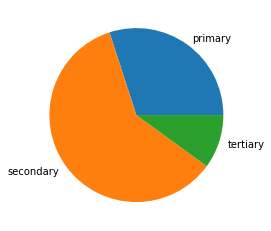

そのうち、申し込んだ人が所属する要素の割合
No data



In [137]:
relationship_default("education")